<a href="https://colab.research.google.com/github/Gau-6426/PCAP/blob/main/Code/Feature_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Gau-6426/PCAP/main/Data/train.csv", index_col="_id", parse_dates=["date"])
df_train.head(10)

,segment_id,date,weekday,period,LOS,s_node_id,e_node_id,length,street_id,max_velocity,street_level,street_name,street_type,long_snode,lat_snode,long_enode,lat_enode
_id,,,,,,,,,,,,,,,,,
0,26,2021-04-16,4,period_0_30,A,366428456,366416066,116,32575820,NaN,4,Nguyễn Văn Bá,tertiary,106.768732,10.841506,106.769254,10.842422
1,33,2020-08-02,6,period_23_30,C,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808
2,33,2020-08-03,0,period_0_00,D,366469460,3792257828,26,32575862,NaN,3,Đường số 5,secondary,106.761957,10.878650,106.762143,10.878808
3,67,2021-03-09,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771
4,67,2021-03-23,1,period_9_30,B,366403668,5755066033,7,32575862,NaN,3,Đường số 5,secondary,106.768412,10.880817,106.768461,10.880771
5,70,2020-08-02,6,period_23_30,D,5816921541,4614188871,8,32575864,40.0,3,Châu Văn Liêm,secondary,106.659032,10.751940,106.659019,10.752017
6,70,2020-08-03,0,period_0_00,E,5816921541,4614188871,8,32575864,40.0,3,Châu Văn Liêm,secondary,106.659032,10.751940,106.659019,10.752017
7,71,2020-08-02,6,period_23_30,E,366441747,5738173336,43,32575869,NaN,4,Lê Văn Thịnh,unclassified,106.765737,10.776592,106.765964,10.776912
8,71,2020-08-03,0,period_0_00,C,366441747,5738173336,43,32575869,NaN,4,Lê Văn Thịnh,unclassified,106.765737,10.776592,106.765964,10.776912


In [50]:
cols = ["segment_id", "street_id", "street_name", "date", "weekday", 
        "length", "max_velocity", "street_level", "street_type", 
        "long_snode", "lat_snode", "long_enode", "lat_enode", "period", "LOS"]
df_train = df_train[cols]
df_train.head()

,segment_id,street_id,street_name,date,weekday,length,max_velocity,street_level,street_type,long_snode,lat_snode,long_enode,lat_enode,period,LOS
_id,,,,,,,,,,,,,,,
0,26,32575820,Nguyễn Văn Bá,2021-04-16,4,116,NaN,4,tertiary,106.768732,10.841506,106.769254,10.842422,period_0_30,A
1,33,32575862,Đường số 5,2020-08-02,6,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_23_30,C
2,33,32575862,Đường số 5,2020-08-03,0,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_0_00,D
3,67,32575862,Đường số 5,2021-03-09,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B
4,67,32575862,Đường số 5,2021-03-23,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B


Feature enrichment and Feature selection

In [51]:
import datetime

# 6h-8h, 16h-19h
peaks = ["period_6_00", "period_6_30", 
         "period_7_00", "period_7_30",
         "period_16_00", "period_16_30", 
         "period_17_00", "period_17_30",
         "period_18_00", "period_18_30"]

def is_special(date):
    # holidays = [(day, month)]
    holidays = [(1,1), (14,2), (8,3), (30,4), 
                (1,5), (1,6), (2,9), (20,10), 
                (20,11), (24,12), (25,12)]
    for holiday in holidays:
        if date.day == holiday[0] and\
           date.month == holiday[1]:
            return True
    return False

In [52]:
df_train["is_weekend"] = df_train["weekday"].apply(lambda x: int(x in [5, 6]))
df_train["is_peak"] = df_train["period"].apply(lambda p: int(p in peaks))
df_train["special_day"] = df_train["date"].apply(lambda date: int(is_special(date)))
print(df_train.head())

     segment_id  street_id    street_name  ... is_weekend  is_peak  special_day
_id                                        ...                                 
0            26   32575820  Nguyễn Văn Bá  ...          0        0            0
1            33   32575862     Đường số 5  ...          1        0            0
2            33   32575862     Đường số 5  ...          0        0            0
3            67   32575862     Đường số 5  ...          0        0            0
4            67   32575862     Đường số 5  ...          0        0            0

[5 rows x 18 columns]


In [53]:
features = ["segment_id", "street_id", "weekday", 
            "length", "street_level", "street_type", 
            "long_snode", "lat_snode", "period", 
            "is_weekend", "is_peak", "special_day"]

Train models

Extend ROC curves for multiclass classification by computing macro-average ROC curve & ROC area

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def classification_report_df(y_true, y_pred):
    classes = np.unique(y_true)
    true = label_binarize(y_true, classes=classes)
    pred = label_binarize(y_pred, classes=classes)
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i, c in enumerate(classes):
        fpr[c], tpr[c], _ = roc_curve(true[:, i], pred[:, i])
        roc_auc[c] = auc(fpr[c], tpr[c])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(true.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_multiclass_roc(y_true, y_pred, plot_title):
    fpr, tpr, roc_auc = classification_report_df(y_true, y_pred)
    classes = fpr.keys()
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= len(classes)
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for c, color in zip(classes, colors):
        plt.plot(fpr[c], tpr[c], color=color, lw=lw,
                 label=f'ROC curve of class {c} (area = {roc_auc[c]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.show()

Plot Feature Importances

In [55]:
def plot_feature_importances(features, feature_importances):
    indices = np.argsort(feature_importances)

    plt.title("Feature Importances")
    plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.show()

Helper functions

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier

def preprocess_dataset(X, y, preprocessor=None, resampler=None, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=0)
    if preprocessor is not None:
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
    if resampler is not None:
        X_train, y_train = resampler.fit_resample(X_train, y_train)
    return X_train, X_val, y_train, y_val

def train_and_validate(X_train, X_val, y_train, y_val, model, plot_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(model, X_val, y_val)
    plot_multiclass_roc(y_val, y_pred, plot_title)

def train_model(X, y, preprocessor=None, resampler=None, 
                model=DummyClassifier(strategy="most_frequent", random_state=0),
                plot_title="Extension ROC to multi-class", test_size=0.2):
    pre = preprocess_dataset(X, y, preprocessor, resampler, test_size)
    train_and_validate(*pre, model, plot_title)

Column preprocessor

In [57]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

num_features = make_column_selector(dtype_exclude=object)
cat_features = make_column_selector(dtype_include=object)

num_pipeline = Pipeline([('numerical_scaler', StandardScaler())])
cat_pipeline = Pipeline([('categorical_encoder', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = make_column_transformer((num_pipeline, num_features), (cat_pipeline, cat_features))

One-Against-All SVM

              precision    recall  f1-score   support

           A       0.73      0.91      0.81      2636
           B       0.64      0.65      0.65       941
           C       0.33      0.17      0.23       803
           D       0.37      0.42      0.39       749
           E       0.24      0.13      0.17       747
           F       0.41      0.40      0.40       813

    accuracy                           0.58      6689
   macro avg       0.45      0.45      0.44      6689
weighted avg       0.54      0.58      0.55      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


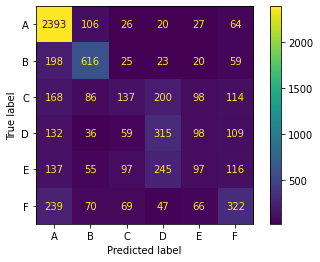

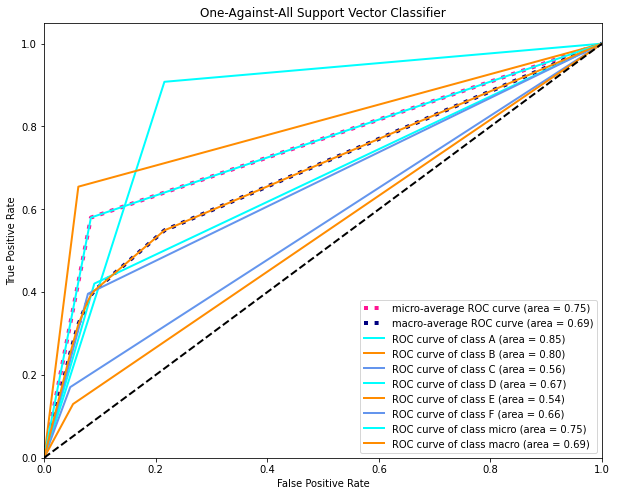

In [58]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

oaa_svm = OneVsRestClassifier(SVC(random_state=0))
train_model(df_train[features], df_train["LOS"], preprocessor=preprocessor, model=oaa_svm, plot_title="One-Against-All Support Vector Classifier")

K-Nearest neighbors

              precision    recall  f1-score   support

           A       0.79      0.90      0.84      2636
           B       0.69      0.66      0.67       941
           C       0.29      0.30      0.30       803
           D       0.34      0.34      0.34       749
           E       0.24      0.18      0.21       747
           F       0.42      0.33      0.37       813

    accuracy                           0.58      6689
   macro avg       0.46      0.45      0.45      6689
weighted avg       0.56      0.58      0.57      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


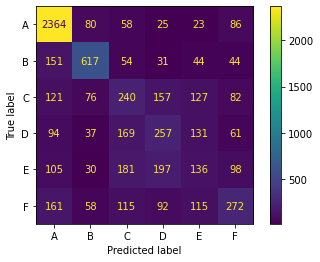

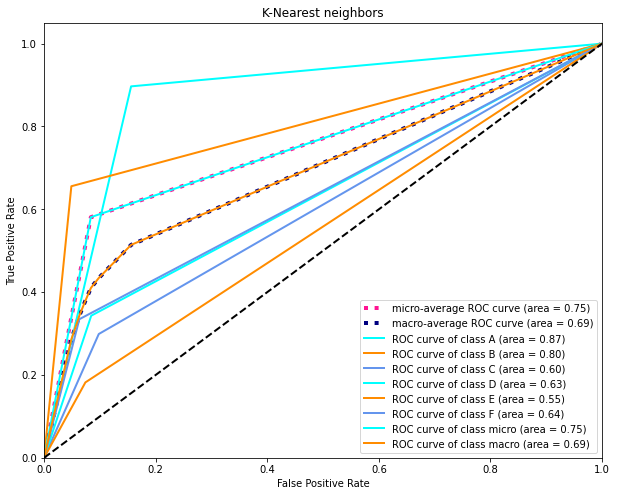

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
train_model(df_train[features], df_train["LOS"], preprocessor=preprocessor, model=knn, plot_title="K-Nearest neighbors")

Multi-Layer Perceptron classifier

              precision    recall  f1-score   support

           A       0.80      0.91      0.85      2636
           B       0.75      0.69      0.72       941
           C       0.33      0.23      0.28       803
           D       0.42      0.44      0.43       749
           E       0.26      0.19      0.22       747
           F       0.43      0.48      0.45       813

    accuracy                           0.61      6689
   macro avg       0.50      0.49      0.49      6689
weighted avg       0.59      0.61      0.60      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


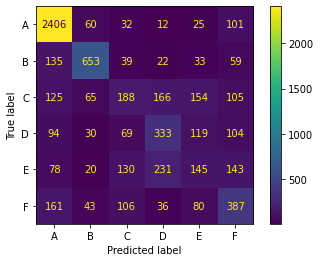

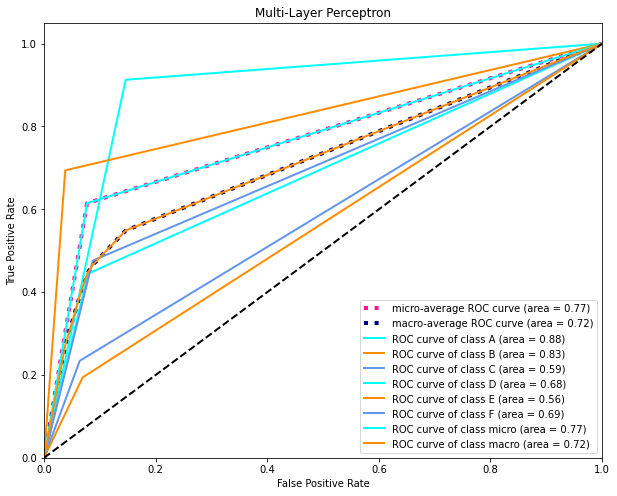

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=1000)
train_model(df_train[features], df_train["LOS"], preprocessor=preprocessor, model=mlp, plot_title="Multi-Layer Perceptron")

Decision Tree

              precision    recall  f1-score   support

           A       0.86      0.86      0.86      2636
           B       0.65      0.68      0.67       941
           C       0.29      0.27      0.28       803
           D       0.30      0.30      0.30       749
           E       0.25      0.25      0.25       747
           F       0.47      0.46      0.46       813

    accuracy                           0.59      6689
   macro avg       0.47      0.47      0.47      6689
weighted avg       0.58      0.59      0.58      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


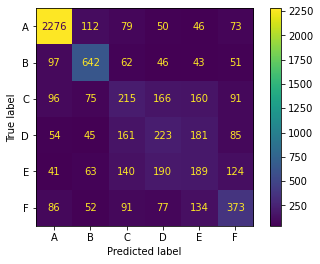

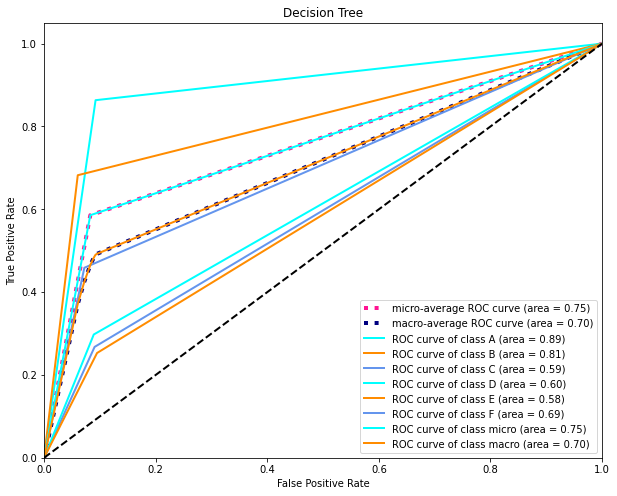

In [61]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
train_model(df_train[features], df_train["LOS"], preprocessor=preprocessor, model=model, plot_title="Decision Tree")

Decision Tree with SMOTE: Over-sampling

              precision    recall  f1-score   support

           A       0.87      0.84      0.86      2636
           B       0.67      0.68      0.68       941
           C       0.27      0.27      0.27       803
           D       0.28      0.29      0.29       749
           E       0.23      0.24      0.24       747
           F       0.45      0.46      0.46       813

    accuracy                           0.58      6689
   macro avg       0.46      0.46      0.46      6689
weighted avg       0.58      0.58      0.58      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


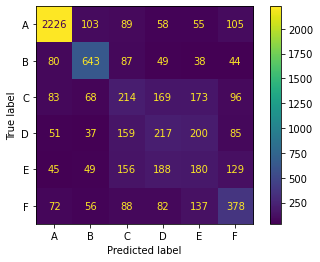

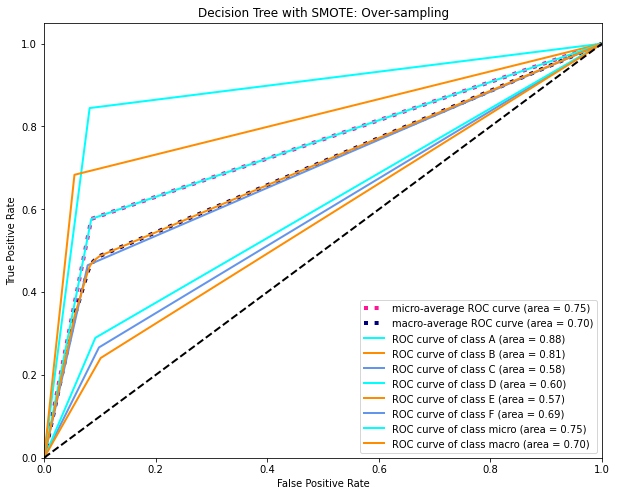

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
train_model(df_train[features], df_train["LOS"], preprocessor, SMOTE(), model, "Decision Tree with SMOTE: Over-sampling")

Decision Tree with SMOTE: Under-sampling

              precision    recall  f1-score   support

           A       0.88      0.85      0.86      2636
           B       0.67      0.71      0.69       941
           C       0.28      0.27      0.28       803
           D       0.29      0.30      0.30       749
           E       0.26      0.28      0.27       747
           F       0.45      0.46      0.45       813

    accuracy                           0.59      6689
   macro avg       0.47      0.48      0.48      6689
weighted avg       0.59      0.59      0.59      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


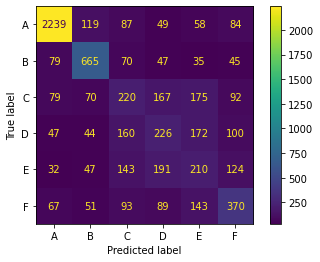

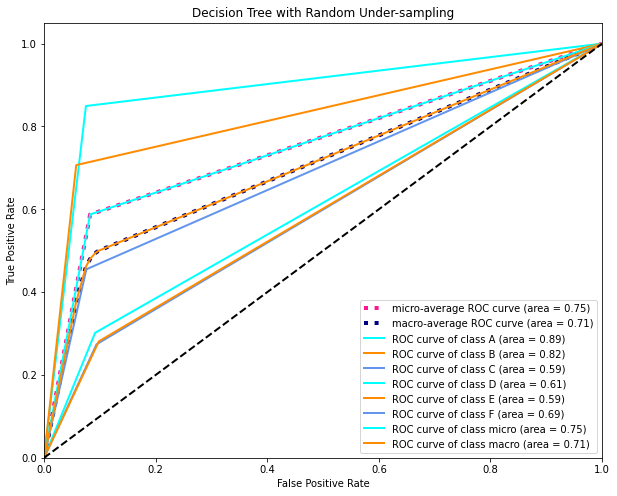

In [63]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

resampler = RandomUnderSampler(sampling_strategy={"A":8000})
model = DecisionTreeClassifier(random_state=0)

train_model(df_train[features], df_train["LOS"], preprocessor, resampler, model, "Decision Tree with Random Under-sampling")

Hybrid: Oversampling & Undersampling

              precision    recall  f1-score   support

           A       0.89      0.84      0.86      2636
           B       0.65      0.70      0.67       941
           C       0.28      0.28      0.28       803
           D       0.31      0.30      0.31       749
           E       0.24      0.26      0.25       747
           F       0.44      0.47      0.45       813

    accuracy                           0.58      6689
   macro avg       0.47      0.47      0.47      6689
weighted avg       0.59      0.58      0.58      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


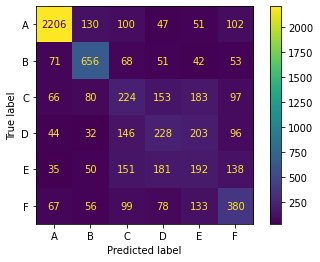

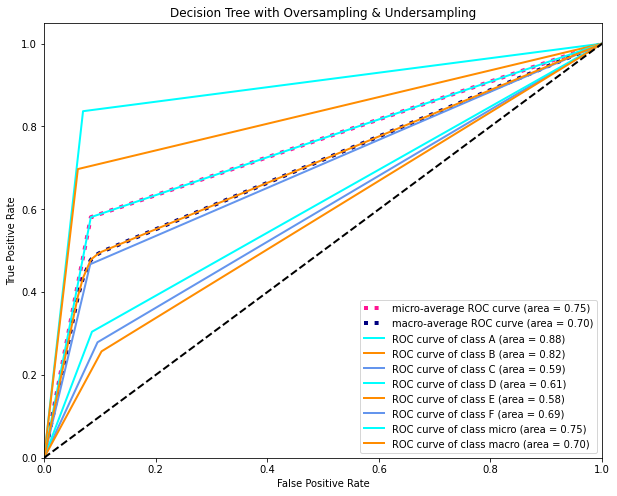

In [64]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

resampler = ImbPipeline(steps=[('o', SMOTE(sampling_strategy={"B":5000, "C":5000, "D":5000, "E":5000, "F":5000})),
                               ('u', RandomUnderSampler(sampling_strategy={"A":8000}))])
model = DecisionTreeClassifier(random_state=0)

train_model(df_train[features], df_train["LOS"], preprocessor, resampler, model,"Decision Tree with Oversampling & Undersampling")

Random Forest with SMOTE

              precision    recall  f1-score   support

           A       0.87      0.89      0.88      2636
           B       0.73      0.71      0.72       941
           C       0.30      0.28      0.29       803
           D       0.35      0.34      0.35       749
           E       0.26      0.26      0.26       747
           F       0.48      0.51      0.49       813

    accuracy                           0.61      6689
   macro avg       0.50      0.50      0.50      6689
weighted avg       0.61      0.61      0.61      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


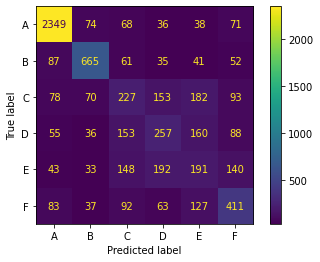

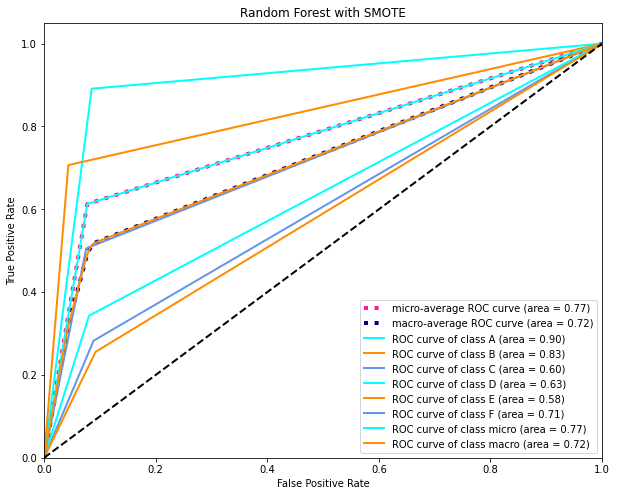

In [65]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
train_model(df_train[features], df_train["LOS"], preprocessor, SMOTE(), forest, "Random Forest with SMOTE")

Cost-sensitive random forest classifier

              precision    recall  f1-score   support

           A       0.83      0.91      0.87      2636
           B       0.72      0.70      0.71       941
           C       0.28      0.24      0.26       803
           D       0.36      0.34      0.35       749
           E       0.26      0.25      0.25       747
           F       0.50      0.49      0.49       813

    accuracy                           0.61      6689
   macro avg       0.49      0.49      0.49      6689
weighted avg       0.59      0.61      0.60      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


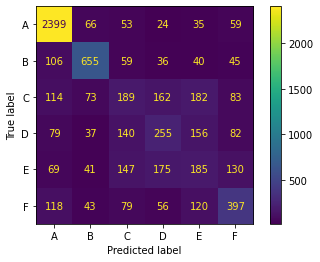

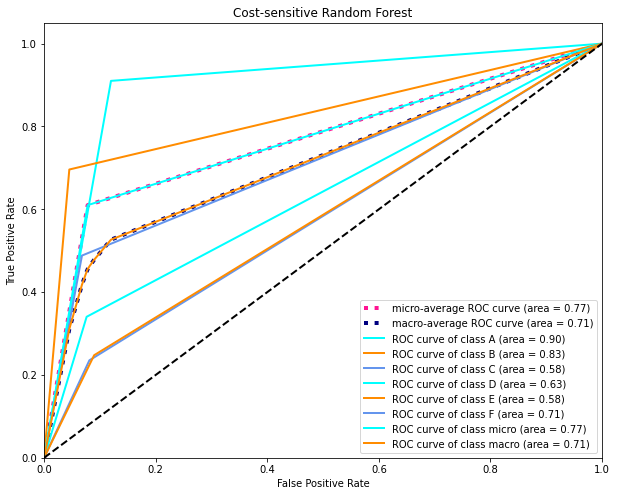

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50, class_weight="balanced")

train_model(df_train[features], df_train["LOS"], preprocessor, model=forest, plot_title="Cost-sensitive Random Forest")

CatBoost

In [68]:
from sklearn.model_selection import train_test_split
import catboost
import ipywidgets

def train_catboost(X, y, cat_features, model, test_size=0.2, plot_title="CatBoost"):
    X_train, X_val, y_train, y_val = train_test_split(df_train[features], df_train["LOS"], test_size=test_size, random_state=1)
    train_pool = catboost.Pool(data=X_train, label=y_train, cat_features=cat_features)
    val_pool = catboost.Pool(data=X_val, label=y_val, cat_features=cat_features)
    model.fit(train_pool, eval_set=val_pool)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(model, X_val, y_val)
    plot_multiclass_roc(y_val, y_pred, plot_title=plot_title)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.115312

bestTest = 0.872752226
bestIteration = 364

Shrink model to first 365 iterations.
              precision    recall  f1-score   support

           A       0.85      0.93      0.89      2697
           B       0.84      0.67      0.75       971
           C       0.29      0.26      0.27       764
           D       0.44      0.47      0.45       735
           E       0.30      0.21      0.25       717
           F       0.48      0.59      0.53       805

    accuracy                           0.65      6689
   macro avg       0.53      0.52      0.52      6689
weighted avg       0.64      0.65      0.64      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


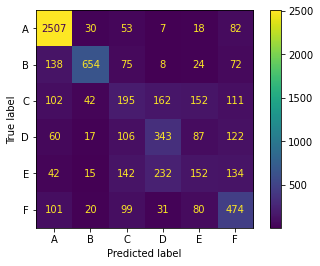

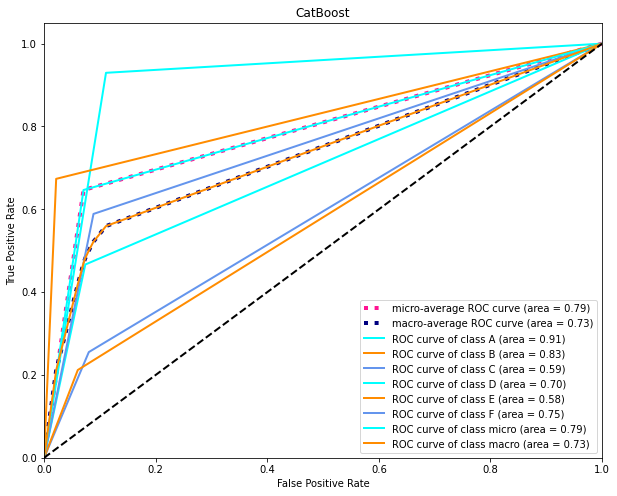

In [69]:
base_cat = catboost.CatBoostClassifier(
    iterations = 1000,
    loss_function = "MultiClass",
    verbose = 100,
    random_seed = 1,
    custom_loss = ["AUC", "Accuracy"],
    save_snapshot = True,
    snapshot_file="base_cat.bkp",
    snapshot_interval=10
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
train_catboost(df_train[features], df_train["LOS"], cat_cols, base_cat)

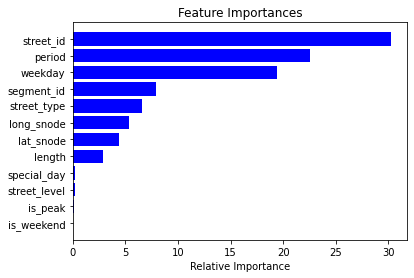

In [70]:
plot_feature_importances(features, base_cat.feature_importances_)

Weighted CatBoost

In [71]:
from sklearn.utils.class_weight import compute_class_weight

classes = df_train["LOS"].unique()
weights = compute_class_weight(class_weight="balanced", classes=classes, y=df_train["LOS"])
class_weights = dict(zip(classes, weights))
display(class_weights)

{'A': 0.41975448109655067,
 'B': 1.1858510638297872,
 'C': 1.4518103672831466,
 'D': 1.5035068788777988,
 'E': 1.45598223615465,
 'F': 1.3630471998043532}

Learning rate set to 0.115312

bestTest = 1.102224852
bestIteration = 415

Shrink model to first 416 iterations.
              precision    recall  f1-score   support

           A       0.93      0.87      0.90      2697
           B       0.80      0.70      0.75       971
           C       0.29      0.31      0.30       764
           D       0.41      0.47      0.44       735
           E       0.27      0.20      0.23       717
           F       0.45      0.62      0.52       805

    accuracy                           0.63      6689
   macro avg       0.52      0.53      0.52      6689
weighted avg       0.65      0.63      0.64      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


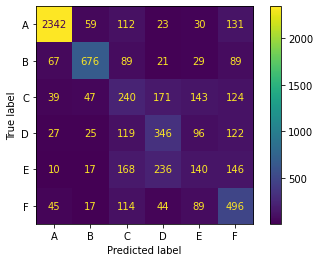

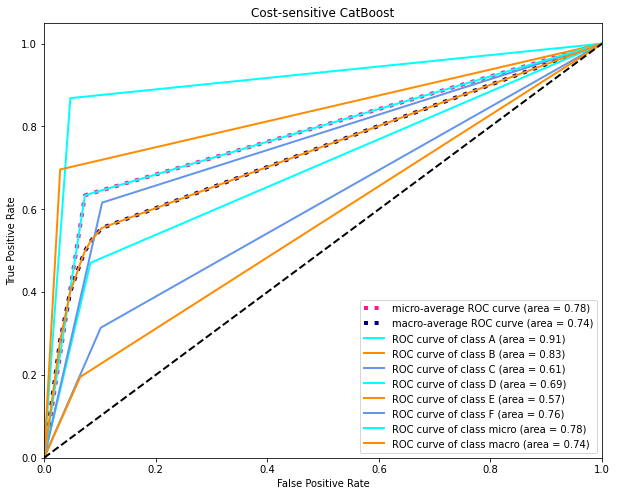

In [72]:
weighted_cat = catboost.CatBoostClassifier(
    iterations = 1000,
    loss_function = "MultiClass",
    verbose = 100,
    random_seed = 1,
    custom_loss = ["AUC"],
    class_weights = class_weights,
    save_snapshot = True,
    snapshot_file="weighted_cat.bkp",
    snapshot_interval=10
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
train_catboost(df_train[features], df_train["LOS"], cat_cols, weighted_cat, plot_title="Cost-sensitive CatBoost")

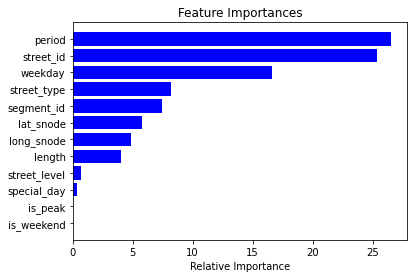

In [47]:
plot_feature_importances(features, weighted_cat.feature_importances_)

In [73]:
params = {
    "learning_rate": [0.03, 0.1, 0.3],
    "depth": [4, 6, 8]
}

tune_model = catboost.CatBoostClassifier(
    iterations = 1000,
    loss_function = "MultiClass",
    verbose = False,
    random_seed = 1,
    custom_loss = ["AUC"],
    class_weights = class_weights,
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
X_train, X_val, Y_train, Y_val = preprocess_dataset(df_train[features], df_train["LOS"], preprocessor)
results = tune_model.grid_search(params, X_train, Y_train)
display(results["params"])


bestTest = 1.26183099
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 1.2618310	best: 1.2618310 (0)	total: 18.4s	remaining: 2m 27s

bestTest = 1.219133614
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 1.2191336	best: 1.2191336 (1)	total: 36.7s	remaining: 2m 8s

bestTest = 1.215684552
bestIteration = 602

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 1.2156846	best: 1.2156846 (2)	total: 54.6s	remaining: 1m 49s

bestTest = 1.225404708
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 1.2254047	best: 1.2156846 (2)	total: 1m 20s	remaining: 1m 40s

best

CatBoostError: ignored

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.6815580	test: 1.6735798	best: 1.6735798 (0)	total: 373ms	remaining: 6m 12s
100:	learn: 1.1210602	test: 1.1199428	best: 1.1199137 (99)	total: 31.1s	remaining: 4m 36s
200:	learn: 1.0603971	test: 1.1037510	best: 1.1037510 (200)	total: 1m 5s	remaining: 4m 18s
300:	learn: 1.0145337	test: 1.1004396	best: 1.1000290 (284)	total: 1m 38s	remaining: 3m 49s
400:	learn: 0.9747643	test: 1.0997735	best: 1.0987931 (356)	total: 2m 12s	remaining: 3m 18s
500:	learn: 0.9411414	test: 1.1002703	best: 1.0987931 (356)	total: 2m 45s	remaining: 2m 44s
600:	learn: 0.9052749	test: 1.1020484	best: 1.0987931 (356)	total: 3m 19s	remaining: 2m 12s
700:	learn: 0.8734026	test: 1.1035554	best: 1.0987931 (356)	total: 3m 53s	remaining: 1m 39s
800:	learn: 0.8425172	test: 1.1063957	best: 1.0987931 (356)	total: 4m 26s	remaining: 1m 6s
900:	learn: 0.8106233	test: 1.1090081	best: 1.0987931 (356)	total: 5m 2s	remaining: 33.2s
999:	learn: 0.7818329	test: 1.1130772	best: 1.0987931 (356)	total: 5m 35s	remaining: 0us

b

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


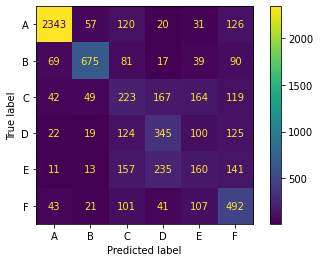

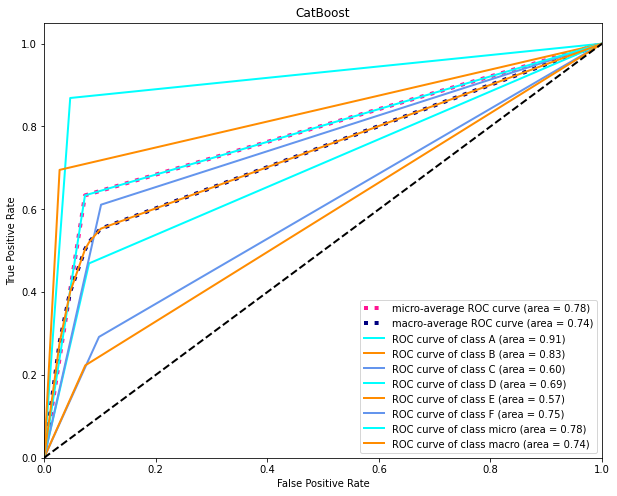

In [74]:
best_clf = catboost.CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.1,
    loss_function = "MultiClass",
    verbose = 100,
    random_seed = 1,
    custom_loss = ["AUC"],
    class_weights = class_weights,
    depth = 6,
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
train_catboost(df_train[features], df_train["LOS"], cat_cols, best_clf)

In [ ]:
plot_feature_importances(features, best_clf.feature_importances_)

In [ ]:
params = {
    "learning_rate": [0.03, 0.1, 0.3],
    "depth": [4, 6, 8]
}

tune_model = catboost.CatBoostClassifier(
    iterations = 1000,
    loss_function = "MultiClass",
    verbose = False,
    random_seed = 1,
    custom_loss = ["AUC"],
    class_weights = class_weights,
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
X_train, X_val, y_train, y_val = preprocess_dataset(df[features], df["LOS"], preprocessor)
results = tune_model.grid_search(params, X_train, y_train)
display(results["params"])

In [ ]:
best_clf = catboost.CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.1,
    loss_function = "MultiClass",
    verbose = 100,
    random_seed = 1,
    custom_loss = ["AUC"],
    class_weights = class_weights,
    depth = 6,
)
cat_cols = ["segment_id", "street_id", "weekday", "street_type", "period"]
train_catboost(df[features], df["LOS"], cat_cols, best_clf)

In [ ]:
plot_feature_importances(features, best_clf.feature_importances_)